#  Figure 1 

In [303]:
import pandas as pd
from pathlib import Path
import random
import yaml
import datetime
import plotly.express as px
import plotly.graph_objs as go
import numpy as np
import ncbi
import datetime
from matplotlib.ticker import FuncFormatter
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [282]:
df_genomes_meta = pd.read_csv("df_genomes_meta.csv", index_col=0)
df_ncbi_strepto_hq = pd.read_csv("df_ncbi_strepto_hq.csv", index_col=0)
df_ncbi_all = pd.read_csv("df_ncbi_all.csv", index_col=0)
df_isolation_src = pd.read_csv("df_isolation_src.csv", index_col=0)
df_bgcs = pd.read_csv("df_bgcs.csv", index_col=0)

# Panel A: Timeline of HQ Streptomyces genomes

In [230]:
# Gather year information
df_year = pd.DataFrame(index = df_ncbi_strepto_hq.index, columns=['Date', 'Year', "Source"])
df_year["Source"] = "NCBI" 
for genome_id in df_year.index:
    date_str = df_ncbi_strepto_hq.loc[genome_id, 'date']
    date_obj = datetime.datetime.strptime(date_str, "%Y-%m-%d")
    df_year.loc[genome_id, 'Year'] = str(date_obj.year)
    df_year.loc[genome_id, 'Date'] = date_str
    

df_internal_strepto_hq = df_genomes_meta[(df_genomes_meta.genus == "Streptomyces") & (df_genomes_meta.quality == "HQ")]
for genome_id in df_internal_strepto_hq.index:
    df_year.loc[genome_id, "Date"] = "2023-12-01"
    df_year.loc[genome_id, "Year"] = "2023"
    df_year.loc[genome_id, "Source"] = "This study*"
    
df_year.sort_values(by='Date', inplace=True)

df = df_year.copy()

# Ensure the 'year' column is of integer type
df['Year'] = df['Year'].astype(int)
df = df.groupby(['Year', 'Source']).size().reset_index(name='counts')
df.sort_values('Year', inplace=True)
df['cumulative_counts'] = df.groupby('Source')['counts'].cumsum()

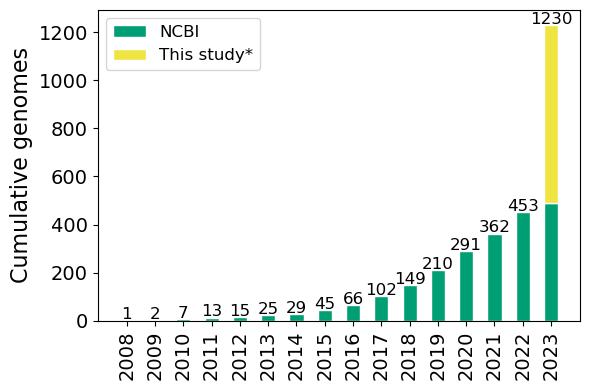

In [231]:
# Plot the bar chart
# Define colors for each source, as per your given colors
colors = {"NCBI": "#009E73", "This study*": "#F0E442"}

# Define order of sources
sources = ["NCBI", "This study*"]

# Calculate total values for each year
total_values = df.groupby('Year')['cumulative_counts'].sum()

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))

# Initialize bottom to 0 for stacking, with an index matching unique years
bottom = pd.Series([0] * len(df['Year'].unique()), index=df['Year'].unique().astype(int))

for source in sources:
    df_filtered = df[df['Source'] == source]
    cumulative_counts = df_filtered.groupby('Year')['cumulative_counts'].sum()
    ax.bar(cumulative_counts.index, cumulative_counts, 
           bottom=bottom.loc[cumulative_counts.index].values, 
           color=colors[source], edgecolor='white', label=source, width=0.5)
    bottom.loc[cumulative_counts.index] += cumulative_counts

# Adding the text on top of the bars
for idx, value in total_values.items():
    ax.text(idx, value + 5, str(int(value)), ha='center', fontsize=12)  # Adjust fontsize as needed

# Set custom x-ticks to ensure all years are displayed
years = df['Year'].unique()  # Assuming 'year' is your x-axis data
ax.set_xticks(years)  # This sets every unique year as an x-tick

# Rotate x-axis labels
ax.set_xticklabels(years, rotation=90, ha='center')  # Set x labels with rotation

# Customize font sizes
ax.set_ylabel('Cumulative genomes', fontsize=16)
ax.legend(fontsize=12)

# Set custom font sizes for x-tick labels
ax.tick_params(axis='x', labelsize=14)  # Change the number for your desired font size

# Set custom font sizes for y-tick labels
ax.tick_params(axis='y', labelsize=14)  # Change the number for your desired font size

# Show the plot
plt.tight_layout()

# Save as SVG
plt.savefig('timeline.svg', format='svg', bbox_inches="tight")

# Save as PNG
plt.savefig('timeline.png', format='png', bbox_inches="tight")

plt.show()

# Panel B: Distribution of Streptomyces HQ across countries

In [25]:
import ncbi.datasets

api_instance = ncbi.datasets.GenomeApi(ncbi.datasets.ApiClient())

df_isolation_src = pd.DataFrame(index=df_ncbi_strepto_hq.index, columns=['isolation_source', 'Country', 'geo_loc_name'])

for genome_id in df_ncbi_strepto_hq.index:
    try:
        genome_summary = api_instance.assembly_descriptors_by_accessions([genome_id])
        
        for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
            if assembly.biosample:
                if assembly.biosample.attributes:
                    for attr in assembly.biosample.attributes:
                        if 'name' in attr.to_dict().keys():
                            attr_name = attr['name']
                            if attr_name == 'isolation_source':
                                if 'value' in attr.to_dict().keys():
                                    attr_value = attr['value']
                                    if attr_value in ['missing', 'Unknown', 'not applicable', 'unknown',
                                                      'Missing', 'NA', 'not collected', 'Not applicable',
                                                      'N/A', '-', 'Not collected']:
                                        df_isolation_src.loc[genome_id, 'isolation_source'] = 'Missing'
                                    else:
                                        df_isolation_src.loc[genome_id, 'isolation_source'] = attr_value
                                else:
                                    df_isolation_src.loc[genome_id, 'isolation_source'] = 'Missing'

                            if attr_name == 'geo_loc_name':
                                if 'value' in attr.to_dict().keys():
                                    attr_value = attr['value']
                                    df_isolation_src.loc[genome_id, attr_name] = attr_value
                                    if ':' in attr_value:
                                        country = attr_value.split(":")[0]
                                    else:
                                        country = attr_value

                                    if country in ['missing', 'Unknown', 'not applicable', 'unknown',
                                                  'Missing', 'NA', 'not collected', 'Not applicable',
                                                  'N/A', '-', 'Not collected']:
                                        df_isolation_src.loc[genome_id, 'Country'] = 'Missing'
                                    elif country in ['suburb of Beijing']:
                                        df_isolation_src.loc[genome_id, 'Country'] = 'China'
                                    else:
                                        df_isolation_src.loc[genome_id, 'Country'] = country
                                else:
                                    df_isolation_src.loc[genome_id, 'Country'] = 'Missing'
                                    df_isolation_src.loc[genome_id, 'geo_loc_name'] = 'Missing'

    except Exception as e:
        print(f"Error processing {genome_id}: {e}")

df_isolation_src.index.name = 'genome_id'
df_isolation_src.fillna('Missing', inplace=True)

Error processing GCF_024442315.1: (500)
Reason: Internal Server Error
HTTP response headers: HTTPHeaderDict({'Date': 'Sun, 10 Dec 2023 22:54:38 GMT', 'Server': 'Apache', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'Content-Security-Policy': 'upgrade-insecure-requests', 'Ncbi-Phid': '939B0BDC0FE721D5000034D7B1C7BB1E.1', 'Content-Type': 'application/json', 'Content-Length': '216', 'X-Datasets-Version': '15.31.2', 'Vary': 'Accept-Encoding', 'X-UA-Compatible': 'IE=Edge', 'X-XSS-Protection': '1; mode=block', 'Connection': 'close'})
HTTP response body: {"error":"Internal Server Error","code":500,"message":"Internal Server Error (For more help, see the NCBI Datasets Documentation at https://www.ncbi.nlm.nih.gov/datasets/docs/) (939B0BDC0FE721D5000034D7B1C7BB1E.1)"}




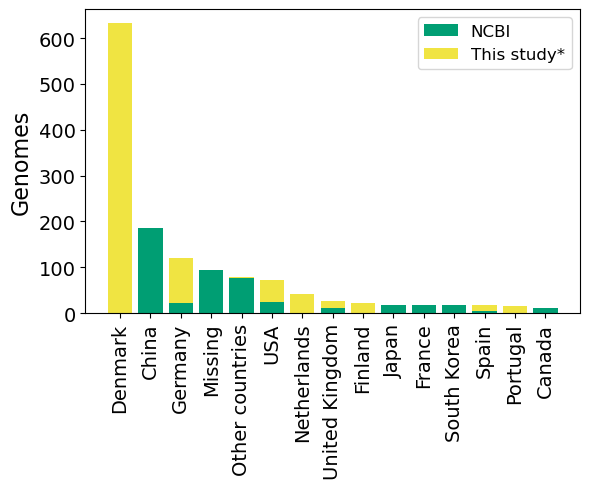

In [55]:
 # Plotting
fig, ax = plt.subplots(figsize=(6, 5))

# Set colors for each dataset
colors = {"NCBI": "#009E73", "This study*": "#F0E442"}

top_countries = df_isolation_src['Country_selected'].value_counts().index.tolist()[:15]

# Create a DataFrame with zeros for all combinations of countries and datasets
df_counts = pd.DataFrame(0, index=top_countries, columns=df_isolation_src['Dataset'].unique())

# Fill in actual counts where available
for dataset in df_counts.columns:
    dataset_data = df_isolation_src[df_isolation_src['Dataset'] == dataset]
    country_counts = dataset_data['Country_selected'].value_counts()
    for country in top_countries:
        if country in country_counts.index:
            df_counts.loc[country, dataset] = country_counts[country]

bar_width = 0.8

for i, dataset in enumerate(df_counts.columns):
    # Adjust the bar position for each dataset
    current_positions = range(len(top_countries))
    
    ax.bar(current_positions, df_counts[dataset], bar_width, color=colors[dataset], label=dataset, 
           bottom=df_counts.iloc[:, :i].sum(axis=1))

# Customize font sizes
ax.set_ylabel('Genomes', fontsize=16)
ax.legend(fontsize=12)

# Set custom font sizes for x-tick labels
ax.set_xticks(range(len(top_countries)))
ax.set_xticklabels(top_countries, rotation=45, ha='center')
ax.tick_params(axis='x', rotation=90, labelsize=14)  # Change the number for your desired font size

# Set custom font sizes for y-tick labels
ax.tick_params(axis='y', labelsize=14)  # Change the number for your desired font size

# Show the plot
plt.tight_layout()

# Save as SVG
plt.savefig('country_dist.svg', format='svg', bbox_inches="tight")

# Save as PNG
plt.savefig('country_dist.png', format='png', bbox_inches="tight")

plt.show()

# Panel C: Sankey diagram with overview of different catgories

In [285]:
df_raw = pd.DataFrame(columns=['genus_init','genus_gtdb', 'quality'])
for genome_id in df_ncbi_all.index:
    ncbi_genus = df_ncbi_all.loc[genome_id, "genus"]
    if ncbi_genus == "Streptomyces":
        df_raw.loc[genome_id, "genus_init"] = "Streptomyces"
    else:
        df_raw.loc[genome_id, "genus_init"] = "non-Streptomyces"

    gtdb_genus = df_filters.loc[genome_id, "genus"]
    if gtdb_genus == "Streptomyces":
        df_raw.loc[genome_id, "genus_gtdb"] = "Streptomyces_G"
    else:
        df_raw.loc[genome_id, "genus_gtdb"] = "non-Streptomyces_G"
    
    df_raw.loc[genome_id, "quality"] = df_filters.loc[genome_id, "quality"]

for genome_id in df_genomes_meta.index:
    df_raw.loc[genome_id, "genus_init"] = "This study*"
    gtdb_genus = df_genomes_meta.loc[genome_id, "genus_gtdb"]
    if gtdb_genus == "g__Streptomyces":
        df_raw.loc[genome_id, "genus_gtdb"] = "Streptomyces_G"
    else:
        df_raw.loc[genome_id, "genus_gtdb"] = "non-Streptomyces_G"
    df_raw.loc[genome_id, "quality"] = df_genomes_meta.loc[genome_id, "quality"] + "_I"

In [286]:
df_raw["genome_id"] = df_raw.index
df_sankey = df_raw.groupby(['genus_init','genus_gtdb', 'quality']).count().iloc[:,:1].reset_index()

In [287]:
color_dict = dict()
color_dict["genus_init"] = {"Streptomyces": "#009E73", "This study*": "#F0E442", "non-Streptomyces": "#009E73"}
color_dict["genus_gtdb"] = {"Streptomyces_G": "#4cc9f0", "non-Streptomyces_G": "#7209b7"}
color_dict["quality"] = {"HQ": "#83c5be", "MQ": "#e9c46a", "LQ": "#e63946", "HQ_I": "#83c5be", "MQ_I": "#e9c46a"}

In [289]:
df = df_sankey
cat_cols=['genus_init', 'genus_gtdb', 'quality']
value_cols='genome_id'

labelList = []
colorList = []
for col in cat_cols:
    labelList = labelList + list(set(df[col].values))
    colorList = colorList + [color_dict[col][label] for label in list(set(df[col].values))]
labelList = list(dict.fromkeys(labelList))

# transform df into a source-target pair
for i in range(len(cat_cols)-1):
    if i==0:
        sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
        sourceTargetDf.columns = ['source','target','count']
    else:
        tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
        tempDf.columns = ['source','target','count']
        sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
    sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
        
# add index for source-target pair
sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
# sourceTargetDf['color'] = [color_quality_dict[target_id] if target_id in color_quality_dict.keys() else '#2a9d8f' for target_id in sourceTargetDf['target']]
    
# creating the sankey diagram
data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 100,
          line = dict(
            color = "black",
            width = 0
          ),
          # label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count'],
          # color = sourceTargetDf['color'],
        )
      )
    
       
fig_data = dict(data=[data])
fig = go.Figure(data=fig_data)

fig.update_layout(font_size=12,
                 width=600,
                height=600,)
fig.write_image("gtdb_sankey.svg")
fig.show()

# Panel D: BGC type overview

In [239]:
df_protoclusters = pd.DataFrame(columns=["type", "count"])
for bgc_id in df_bgcs.index:
    product_list = df_bgcs.loc[bgc_id, "product"][1:-1].split(",")
    for prod in product_list:
        type = prod.strip()[1:-1]
        if type not in df_protoclusters.index:
            df_protoclusters.loc[type, "type"] = type
            df_protoclusters.loc[type, "count"] = 1
        else:
            df_protoclusters.loc[type, "count"] = df_protoclusters.loc[type, "count"] + 1

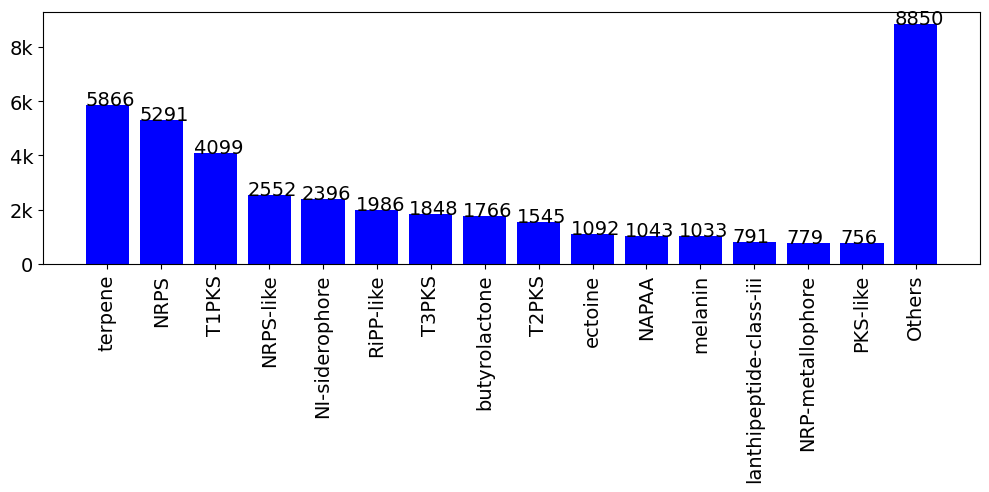

In [271]:
df = df_protoclusters.copy()

# Sort the DataFrame by count in descending order
df = df.sort_values(by='count', ascending=False)

# Select the top 15 types
top_15 = df.head(15)

# Sum the counts of the remaining types
others_count = df.iloc[15:]['count'].sum()

# Create a new row for 'Others'
others_row = pd.DataFrame({'type': ['Others'], 'count': [others_count]})

# Concatenate the top 15 and 'Others' rows
df_combined = pd.concat([top_15, others_row])


# Set the figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Create horizontal bar chart
bars = ax.bar(df_combined['type'], df_combined['count'], color='blue')

# Set the font size
ax.tick_params(axis='both', which='major', labelsize=14)

# Format x-axis ticks to display as 2k, 4k, 6k, etc.
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0g}k'.format(x / 1000) if x > 0 else '0'))

# Rotate x-axis ticks by 80 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Add counts on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), int(yval)+100, yval,
                 va='center', ha='left', fontsize=14)
    # else:
    #     plt.text(bar.get_x() + bar.get_width() / 2, int(yval) - 1500, yval,
    #              va='center', ha='left', fontsize=14, color='white')

# Show the plot
plt.tight_layout()

# Save as SVG
plt.savefig('bgc_protoclusters_dist.svg', format='svg', bbox_inches="tight")

# Save as PNG
plt.savefig('bgc_protoclusters_dist.png', format='png', bbox_inches="tight")

plt.show()

# Stats description

### Taxonomic stats

In [317]:
print("Total genera:", len(df_genomes_meta.genus_gtdb.value_counts()) -1)
df_genomes_meta.genus_gtdb.value_counts()

Total genera: 27


genus_gtdb
g__Streptomyces         885
g__Micromonospora        36
g__Kitasatospora         27
g__Nocardia              21
g__Kribbella             11
g__Amycolatopsis          8
g__Streptosporangium      7
g__Microbispora           5
g__Nonomuraea             4
g__Kocuria                4
g__Nocardioides           3
g__Spirillospora          3
g__Embleya                2
g__Rhodococcus_C          2
g__Micromonospora_G       2
g__                       2
g__Mycobacterium          1
g__Aldersonia             1
g__Kineococcus            1
g__Micrococcus            1
g__Williamsia_A           1
g__Dactylosporangium      1
g__Actinoplanes           1
g__Lentzea                1
g__Sphaerisporangium      1
g__Micromonospora_E       1
g__Actinoallomurus        1
g__Actinomycetospora      1
Name: count, dtype: int64

In [311]:
print("Unassigned genus:", df_genomes_meta[df_genomes_meta.genus_gtdb == "g__"].index)

Unassigned genus: Index(['NBC_01635', 'NBC_01309'], dtype='object', name='genome_id')


In [325]:
df_genomes_meta_1032 = df_genomes_meta.drop(index=["NBC_01635", "NBC_01309"])
print("Total species detected:", len(df_genomes_meta_1032.species_gtdb.value_counts()) -1)
print("Total genomes with assigned species:", df_genomes_meta_1032[df_genomes_meta_1032.species_gtdb != "s__"].shape)
df_genomes_meta_1032.species_gtdb.value_counts()

Total species detected: 145
Total genomes with assigned species: (570, 12)


species_gtdb
s__             462
anulatus         39
sp003846175      26
albidoflavus     25
canus            24
               ... 
sp001280005       1
sp900091725       1
sp000720145       1
xinghaiensis      1
diastaticus       1
Name: count, Length: 146, dtype: int64

In [ ]:
df_genomes_meta_1032 = df_genomes_meta.drop(index=["NBC_01635", "NBC_01309"])
print("Total species detected:", len(df_genomes_meta_1032.species_gtdb.value_counts()) -1)
print("Total genomes with assigned species:", df_genomes_meta_1032[df_genomes_meta_1032.species_gtdb != "s__"].shape)
df_genomes_meta_1032.species_gtdb.value_counts()

In [330]:
df_mash = pd.read_csv("df_mash.csv", index_col=0)
genomes_with_unassigned_species = df_genomes_meta_1032[df_genomes_meta_1032.species_gtdb == "s__"].index
df_mash_novel = df_mash.loc[genomes_with_unassigned_species, genomes_with_unassigned_species]
df_mash_novel

genome_id,NBC_00193,NBC_01306,NBC_01571,NBC_00201,NBC_01142,NBC_00086,NBC_00347,NBC_01381,NBC_00310,NBC_01565,...,NBC_01310,NBC_01490,NBC_01615,NBC_00405,NBC_00669,NBC_00569,NBC_01104,NBC_00536,NBC_01116,NBC_01001
genome_id,,,,,,,,,,,,,,,,,,,,,
NBC_00193,0.000000,0.178173,0.210897,0.197292,0.191731,0.056532,0.008615,0.263022,0.230110,0.132399,...,0.122140,0.295981,0.203604,0.263022,0.203604,0.197292,0.182269,0.132399,0.203604,0.124491
NBC_01306,0.178173,0.000000,0.219531,0.210897,0.178173,0.167688,0.186761,0.203604,0.186761,0.174408,...,0.170926,0.243761,0.191731,0.295981,0.191731,0.219531,0.178173,0.174408,0.174408,0.178173
NBC_01571,0.210897,0.219531,0.000000,0.159146,0.178173,0.203604,0.219531,0.186761,0.170926,0.186761,...,0.186761,0.295981,0.132399,1.000000,0.197292,0.182269,0.178173,0.182269,0.197292,0.197292
NBC_00201,0.197292,0.210897,0.159146,0.000000,0.174408,0.203604,0.197292,0.174408,0.167688,0.191731,...,0.191731,0.219531,0.132399,0.295981,0.210897,0.191731,0.174408,0.178173,0.191731,0.203604
NBC_01142,0.191731,0.178173,0.178173,0.174408,0.000000,0.191731,0.197292,0.167688,0.182269,0.174408,...,0.182269,0.295981,0.167688,1.000000,0.197292,0.174408,0.170926,0.174408,0.174408,0.186761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NBC_00569,0.197292,0.219531,0.182269,0.191731,0.174408,0.197292,0.203604,0.149777,0.182269,0.182269,...,0.219531,0.263022,0.178173,0.263022,0.219531,0.000000,0.191731,0.186761,0.197292,0.203604
NBC_01104,0.182269,0.178173,0.178173,0.174408,0.170926,0.178173,0.191731,0.174408,0.186761,0.174408,...,0.174408,1.000000,0.170926,0.295981,0.210897,0.191731,0.000000,0.174408,0.145727,0.186761
NBC_00536,0.132399,0.174408,0.182269,0.178173,0.174408,0.133864,0.140258,0.210897,0.197292,0.136948,...,0.132399,0.295981,0.174408,0.295981,0.210897,0.186761,0.174408,0.000000,0.182269,0.133864


In [332]:
import networkx as nx
from community import community_louvain
from collections import Counter

# create a graph from the dataframe
G = nx.from_pandas_adjacency(df_mash_novel)

# filter edges below the cutoff value and add singleton nodes
filtered_G = nx.Graph()
for u, v, w in G.edges(data=True):
    if w['weight'] < 0.05:
        filtered_G.add_edge(u, v, weight=w['weight'])

# add nodes with no edges (singleton nodes)
for node in G:
    if node not in filtered_G:
        filtered_G.add_node(node)

# find communities
partition = community_louvain.best_partition(filtered_G)

# Count the abundance of each community
community_abundance = Counter(partition.values())

# Sort communities by abundance
sorted_communities = sorted(community_abundance.items(), key=lambda item: item[1], reverse=True)

# print communities
idx = 1
for i, com in sorted_communities:
    list_genomes = [nodes for nodes in partition.keys() if partition[nodes] == i]
    df_genomes_meta.loc[list_genomes, "Mash_species"] = "sp_mash_{:03d}".format(idx)
    idx = idx + 1

In [346]:
counts = (df_genomes_meta.Mash_species.value_counts() == 1)*1
counts.sum()

171

In [347]:
df_genomes_meta.Mash_species.value_counts()

Mash_species
sp_mash_001    28
sp_mash_002    16
sp_mash_003    13
sp_mash_004    10
sp_mash_005    10
               ..
sp_mash_132     1
sp_mash_133     1
sp_mash_134     1
sp_mash_135     1
sp_mash_244     1
Name: count, Length: 244, dtype: int64

In [352]:
counts = (df_genomes_meta.species_gtdb.value_counts() == 1)*1
counts.sum()

58

In [ ]:
df_genomes_meta.to_csv("df_genomes_meta.csv")

In [357]:
df_ncbi_strepto_hq

,genome_id.1,genus,source,species,quality,completeness,contamination,N50,contigs,genome_len,gc,assembly_level,year,date
genome_id,,,,,,,,,,,,,,
GCF_000009765.2,GCF_000009765.2,Streptomyces,NCBI,avermitilis,HQ,99.890000,0.790000,9025608,2,9119895,0.707014,Complete Genome,2016,2016-03-24
GCF_000010605.1,GCF_000010605.1,Streptomyces,NCBI,griseus,HQ,99.840000,0.000000,8545929,1,8545929,0.722274,Complete Genome,2008,2008-04-08
GCF_000091305.1,GCF_000091305.1,Streptomyces,NCBI,scabiei,HQ,100.000000,0.000000,10148695,1,10148695,0.714528,Complete Genome,2009,2009-10-06
GCF_000092385.1,GCF_000092385.1,Streptomyces,NCBI,milbemycinicus,HQ,99.740000,1.960000,11936683,1,11936683,0.707546,Complete Genome,2010,2010-05-28
GCF_000147815.2,GCF_000147815.2,Streptomyces,NCBI,violaceusniger_A,HQ,100.000000,1.050000,10657107,3,11138313,0.708764,Complete Genome,2011,2011-08-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_900236475.1,GCF_900236475.1,Streptomyces,NCBI,chartreusis_D,HQ,100.000000,0.000000,8983317,1,8983317,0.712257,Complete Genome,2018,2018-01-10
GCF_900236505.1,GCF_900236505.1,Streptomyces,NCBI,chartreusis_D,HQ,100.000000,0.000000,8983317,1,8983317,0.712257,Complete Genome,2018,2018-01-10
GCF_904440635.1,GCF_904440635.1,Streptomyces,NCBI,cyaneofuscatus,HQ,99.840000,0.450000,7838151,1,7838151,0.715815,Complete Genome,2021,2021-01-27


In [359]:
df_raw.to_csv("df_sankey.csv")

In [361]:
df_ncbi_strepto_hq.to_csv("df_ncbi_strepto.csv")